In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, IterableDataset
from chronos import BaseChronosPipeline
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_auc_score, precision_recall_curve,
    roc_curve, auc
)
import seaborn as sns


import os
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

from modules import * 

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
# load parquet files
data_path = Path("../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

##unsafe
# for file_path in list((notebooks_path / data_path).glob("*.parquet")):
#     print(f"Reading {file_path}")
#     # retrieve the name of the file without the extension for all OS
#     data = pd.read_parquet(file_path)
#     # if "Time" in df.columns:
#     #     df["Time"] = pd.to_datetime(df["Time"])
#     data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0].replace("-", "_")] = data

for file_path in (notebooks_path / data_path).glob("set*.parquet"):
    var_name = file_path.stem.replace("-", "_")
    globals()[var_name] = pd.read_parquet(file_path)
    print(f"Reading {file_path} -> {var_name}")


ID_vars = ["PatientID", "Time", "RecordID"] # TODO 
# stationary variables
stationary_vars = ["Age", "Gender", "Height"] #, "ICUType"]
# dynamic variables
dynamic_vars = set_a.columns.difference(stationary_vars + ID_vars + ['In-hospital_death']).tolist()

feature_cols = dynamic_vars + stationary_vars

Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a-filled.parquet -> set_a_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b.parquet -> set_b
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-a.parquet -> set_a
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c-filled.parquet -> set_c_filled
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-c.parquet -> set_c
Reading /home/pbaertschi/ICU-TimeSeries-Mortality-Prediction/notebooks/4_Foundation_Models/../../data/set-b-filled.parquet -> set_b_filled


In [3]:
def preprocess_parquet_for_lstm(key, scaler=None, fit_scaler=False):
    labelname = 'In-hospital_death'
    df = globals()[f"set_{key}_filled"].copy()

    # Sort and fill NaNs
    df = df.sort_values(["RecordID", "Time"])
    df[feature_cols] = df[feature_cols].fillna(0)

    # raise NotImplementedError("Encode cathegories")

    # --- Fit scaler on all feature data if requested ---
    if fit_scaler or scaler is None:
        scaler = StandardScaler()
        scaler.fit(df[feature_cols])

    # --- Apply scaling ---
    df[feature_cols] = scaler.transform(df[feature_cols])

    # Group by patient
    X = []
    y = []
    for pid, group in df.groupby("RecordID"):
        group = group.sort_values("Time")
        X.append(group[feature_cols].values)
        y.append(group[labelname].iloc[0])

    X_tensor = torch.tensor(np.stack(X)).float()  # (n_patients, seq_len, n_features)
    y_tensor = torch.tensor(y).float()            # (n_patients,)

    return X_tensor, y_tensor, scaler  # return scaler for reuse on val/test


X_train, y_train, fitted_scaler = preprocess_parquet_for_lstm("a", fit_scaler = True)
# len(preprocess_parquet_for_lstm("b", scaler = fitted_scaler))
X_val, y_val , _    = preprocess_parquet_for_lstm("b", scaler = fitted_scaler)
X_test, y_test , _  = preprocess_parquet_for_lstm("c", scaler = fitted_scaler)


# extract dimensions
num_patients, sequence_length, num_features  = X_train.size()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load the pretrained Chronos model
model_id = "amazon/chronos-t5-small"  # Example model; choose the one that fits your needs
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map=device,  # use "cpu" for CPU inference
    torch_dtype=torch.float16,
)
# Manually move tokenizer boundaries to match model device
pipeline.tokenizer.boundaries = pipeline.tokenizer.boundaries.to(pipeline.model.device)

# Fix Chronos tokenizer device mismatch when appending EOS token
def patched_append_eos_token(self, token_ids, attention_mask):
    device = token_ids.device
    batch_size = token_ids.shape[0]
    eos_tokens = torch.full((batch_size, 1), fill_value=self.config.eos_token_id, device=device)
    eos_mask = torch.full((batch_size, 1), fill_value=True, device=device)
    token_ids = torch.concat((token_ids, eos_tokens), dim=1)
    attention_mask = torch.concat((attention_mask, eos_mask), dim=1)
    return token_ids, attention_mask

# Patch the method
pipeline.tokenizer._append_eos_token = patched_append_eos_token.__get__(pipeline.tokenizer)

In [5]:
# X_train_embeddings = get_chronos_embeddings(X_train, num_features, pipeline, return_stack = False)
# X_val_embeddings = get_chronos_embeddings(X_val, num_features, pipeline, return_stack = False)
# X_test_embeddings = get_chronos_embeddings(X_test, num_features, pipeline, return_stack = False)
# torch.save(X_train_embeddings, notebooks_path / data_path / Path('X_train_embeddings_Q431.pt'))
# torch.save(X_val_embeddings, notebooks_path / data_path / Path('X_val_embeddings_Q431.pt'))
# torch.save(X_test_embeddings, notebooks_path / data_path / Path('X_test_embeddings_Q431.pt'))

## Part 1: fixed pooling

In [6]:
# ==== 1. Define Model ====
class LinearProbe(nn.Module):
    def __init__(self, input_dim, n_classes = 1):
        super().__init__()
        self.layer = nn.Linear(input_dim, n_classes)

    def forward(self, x):
        x_flat = x.view(x.shape[0], -1) # flatten all dimensions but batch
        # print(x_flat.shape)
        return self.layer(x_flat).squeeze(-1)

X_train_embeddings = torch.load(notebooks_path / data_path / Path('X_train_embeddings_Q431.pt')).float()
X_val_embeddings = torch.load(notebooks_path / data_path / Path('X_val_embeddings_Q431.pt')).float()
X_test_embeddings = torch.load(notebooks_path / data_path / Path('X_test_embeddings_Q431.pt')).float()

x = X_train_embeddings[0].unsqueeze(0)

lp = LinearProbe(input_dim = x.view(1, -1).shape[-1])
lp(x).shape
# lpP = LinearProbe(input_dim=, num_segments =

torch.Size([1])

In [7]:
# ==== 2. Training & Evaluation Logic ====
def evaluate(model, loader, device):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_logits.append(probs.cpu())
            all_labels.append(yb.cpu())
    y_true = torch.cat(all_labels).numpy()
    y_score = torch.cat(all_logits).numpy()
    
    # print("y_true:", np.unique(y_true))
    # print("y_score shape:", y_score.shape, "dtype:", y_score.dtype)

    return {
        'AUROC': roc_auc_score(y_true, y_score),
        'AUPRC': average_precision_score(y_true, y_score)
    }
    
def train_model(X_train, y_train, X_val, y_val, X_test, y_test, model, 
                epochs=20, batch_size=32, lr=1e-3):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Wrap tensors in datasets
    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    test_ds = TensorDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # Define model
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        for xb, yb in train_loader:
            # print(xb.shape)
            xb, yb = xb.to(device), yb.to(device).float()
            logits = model(xb)
            # print(logits.device)
            # return
            # print(logits.shape)
            # print(yb.shape)
            # return
            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_metrics = evaluate(model, val_loader, device)
        print(f"[Epoch {epoch+1}] Val AUROC: {val_metrics['AUROC']:.4f}, AUPRC: {val_metrics['AUPRC']:.4f}")
        # return

    print("✅ Finished training. Evaluating on test set...")
    test_metrics = evaluate(model, test_loader, device)
    print(f"Test AUROC: {test_metrics['AUROC']:.4f}, AUPRC: {test_metrics['AUPRC']:.4f}")

    return model, test_metrics

model = LinearProbe(input_dim = x.view(1, -1).shape[-1])
# print(x.view(1, -1).shape[-1])
model, test_metrics = train_model(X_train_embeddings, y_train, X_val_embeddings, y_val, X_test_embeddings, y_test, model, epochs=20, batch_size=32, lr=1e-3)

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1] Val AUROC: 0.7419, AUPRC: 0.3583
[Epoch 2] Val AUROC: 0.7610, AUPRC: 0.3813
[Epoch 3] Val AUROC: 0.7721, AUPRC: 0.3961
[Epoch 4] Val AUROC: 0.7784, AUPRC: 0.4071
[Epoch 5] Val AUROC: 0.7831, AUPRC: 0.4199
[Epoch 6] Val AUROC: 0.7851, AUPRC: 0.4206
[Epoch 7] Val AUROC: 0.7870, AUPRC: 0.4255
[Epoch 8] Val AUROC: 0.7887, AUPRC: 0.4300
[Epoch 9] Val AUROC: 0.7898, AUPRC: 0.4349
[Epoch 10] Val AUROC: 0.7912, AUPRC: 0.4367
[Epoch 11] Val AUROC: 0.7927, AUPRC: 0.4401
[Epoch 12] Val AUROC: 0.7937, AUPRC: 0.4423
[Epoch 13] Val AUROC: 0.7939, AUPRC: 0.4434
[Epoch 14] Val AUROC: 0.7944, AUPRC: 0.4454
[Epoch 15] Val AUROC: 0.7947, AUPRC: 0.4464
[Epoch 16] Val AUROC: 0.7958, AUPRC: 0.4474
[Epoch 17] Val AUROC: 0.7967, AUPRC: 0.4460
[Epoch 18] Val AUROC: 0.7966, AUPRC: 0.4485
[Epoch 19] Val AUROC: 0.7970, AUPRC: 0.4501
[Epoch 20] Val AUROC: 0.7979, AUPRC: 0.4520
✅ Finished training. Evaluating on test set...
Test AUROC: 0.7829, AUPRC: 0.4132


## Part 2: learnt pooling

In [8]:
# # first we need to get the stacked embeddings -> these are very memory intensive so we can only have one in memory at a time
# X_train_embeddings = get_chronos_embeddings(X_train, num_features, pipeline, return_stack = True)
# torch.save(X_train_embeddings, notebooks_path / data_path / Path('X_train_embeddings_Q431_stacked.pt'))
# del X_train_embeddings

In [9]:
# X_val_embeddings = get_chronos_embeddings(X_val, num_features, pipeline, return_stack = True)
# torch.save(X_val_embeddings, notebooks_path / data_path / Path('X_val_embeddings_Q431_stacked.pt'))
# del X_val_embeddings

In [10]:
# X_test_embeddings = get_chronos_embeddings(X_test, num_features, pipeline, return_stack = True)
# torch.save(X_test_embeddings, notebooks_path / data_path / Path('X_test_embeddings_Q431_stacked.pt'), _use_new_zipfile_serialization=False)
# del X_test_embeddings

In [11]:
# torch.save(y_train, notebooks_path / data_path / "y_train_Q431.pt")
# torch.save(y_test, notebooks_path /data_path / "y_test_Q431.pt")

In [12]:
# test the model dimensions   
X_embeddings = torch.load(notebooks_path / data_path / Path('X_train_embeddings_Q431_stacked.pt'))
patients, num_segments, tokens, features = X_embeddings.shape
# extract tensor to test the shape
X_tensor = X_embeddings[0].unsqueeze(0)
del X_embeddings

In [13]:
class TensorChunkDataset(IterableDataset):
    def __init__(self, file_path, batch_size, label_file=None):
        super().__init__()
        self.file_path = file_path
        self.batch_size = batch_size
        self.label_file = label_file

    def __iter__(self):
        data = torch.load(self.file_path, map_location='cpu')  # Lazy load on each worker
        num_batches = data.size(0) // self.batch_size
        for i in range(num_batches):
            x_batch = data[i*self.batch_size:(i+1)*self.batch_size]
            if self.label_file:
                labels = torch.load(self.label_file, map_location='cpu')
                y_batch = labels[i*self.batch_size:(i+1)*self.batch_size]
                yield x_batch, y_batch
            else:
                yield x_batch

def train_model(model, train_loader, device, epochs=10, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # assuming binary classification

    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            # print(x_batch.size())
            y_batch = y_batch.to(device).float()

            # flatten (sequence, feature_embedding) -> -1
            # x_batch = x_batch.view(x_batch.size(0), x_batch.size(1), -1)

            logits = model(x_batch)
            loss = criterion(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
@torch.no_grad()
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).float()
        # print(x_batch.size())
        # x_batch = x_batch.view(x_batch.size(0), x_batch.size(1), -1)

        logits = model(x_batch)
        probs = torch.sigmoid(logits)

        all_preds.append(probs.cpu())
        all_labels.append(y_batch.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_prob = torch.cat(all_preds).numpy()
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    prc_auc = auc(recall, precision)

    print(f"Test Accuracy: {acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PRC AUC: {prc_auc:.4f}")
    print("Confusion Matrix:\n", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot PRC Curve
    plt.figure()
    plt.plot(recall, precision, label=f"PRC curve (AUC = {prc_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
class LinearProbe_LearnablePooling(nn.Module): 
    def __init__(self, input_dim, num_segments, n_classes = 1):
        super().__init__()
        # pooling weights 
        self.segment_weights = nn.Parameter(torch.randn(1, num_segments, 1, 1))

        # linear probe
        self.layer = nn.Linear(input_dim, n_classes)

    def forward(self, x):
        # weight
        batch_size = x.shape[0]
        # Shape: (1, num_segments, 1) -> (batch_size, num_segments, 1, 1)
        weights = F.softmax(self.segment_weights, dim=1)  # softmax over segments
        # print(weights.shape, x.shape)
        # raise Exception()
        weighted = x * weights  # broadcasting over batch and feature dim
        # print(weighted.shape)
        pooled = weighted.sum(dim=1).view(batch_size, -1)  # sum over segments
        pooled.shape
        # print(pooled.shape)
        return self.layer(pooled).squeeze(-1)

model = LinearProbe_LearnablePooling(input_dim = tokens * features, num_segments = num_segments)
print(model(X_tensor).shape)

torch.Size([1])


In [21]:
train_file = notebooks_path / data_path / "X_train_embeddings_Q431_stacked.pt"
train_labels = notebooks_path / data_path / "y_train_Q431.pt"
test_file = notebooks_path / data_path / "X_test_embeddings_Q431_stacked.pt"
test_labels = notebooks_path / data_path / "y_test_Q431.pt"

# hypers
batch_size = 32

# streamed train dataset
train_dataset = TensorChunkDataset(train_file, batch_size=batch_size, label_file=train_labels)
train_loader = DataLoader(train_dataset, batch_size=None)

# stream test dataset
test_dataset = TensorChunkDataset(test_file, batch_size=batch_size, label_file=test_labels)
test_loader = DataLoader(test_dataset, batch_size=None)


model = LinearProbe_LearnablePooling(input_dim = tokens * features, num_segments = num_segments)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train
train_model(model, train_loader, device, epochs = 40)



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Loss: 50.8121
Epoch 2/40, Loss: 48.5869
Epoch 3/40, Loss: 47.8249
Epoch 4/40, Loss: 47.1670
Epoch 5/40, Loss: 46.5715
Epoch 6/40, Loss: 46.0199
Epoch 7/40, Loss: 45.5009
Epoch 8/40, Loss: 45.0067
Epoch 9/40, Loss: 44.5309
Epoch 10/40, Loss: 44.0684
Epoch 11/40, Loss: 43.6147
Epoch 12/40, Loss: 43.1659
Epoch 13/40, Loss: 42.7188
Epoch 14/40, Loss: 42.2706
Epoch 15/40, Loss: 41.8191
Epoch 16/40, Loss: 41.3625
Epoch 17/40, Loss: 40.8998
Epoch 18/40, Loss: 40.4303
Epoch 19/40, Loss: 39.9542
Epoch 20/40, Loss: 39.4719
Epoch 21/40, Loss: 38.9844
Epoch 22/40, Loss: 38.4929
Epoch 23/40, Loss: 37.9989
Epoch 24/40, Loss: 37.5036
Epoch 25/40, Loss: 37.0082
Epoch 26/40, Loss: 36.5134
Epoch 27/40, Loss: 36.0198
Epoch 28/40, Loss: 35.5275
Epoch 29/40, Loss: 35.0367
Epoch 30/40, Loss: 34.5471
Epoch 31/40, Loss: 34.0585
Epoch 32/40, Loss: 33.5706
Epoch 33/40, Loss: 33.0833
Epoch 34/40, Loss: 32.5963
Epoch 35/40, Loss: 32.1094
Epoch 36/40, Loss: 31.6226
Epoch 37/40, Loss: 31.1357
Epoch 38/4

Test Accuracy: 0.8512
ROC AUC: 0.6925
PRC AUC: 0.2841
Confusion Matrix:
 [[3362   53]
 [ 542   43]]


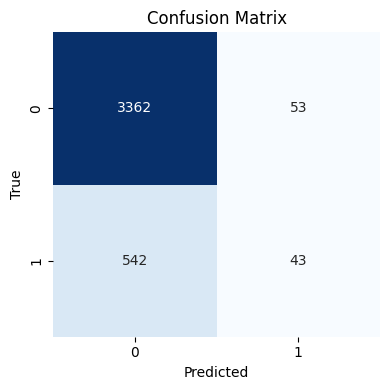

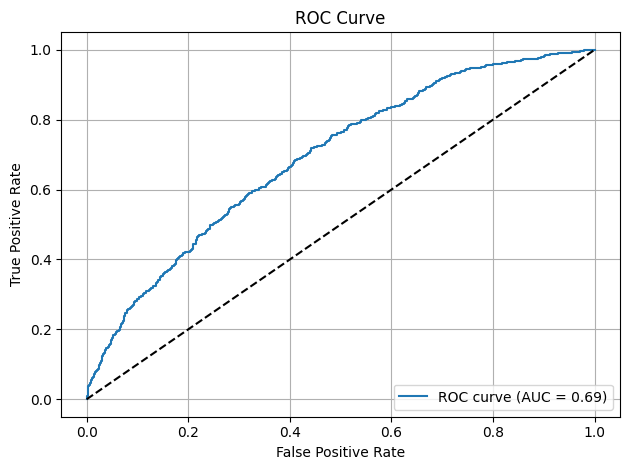

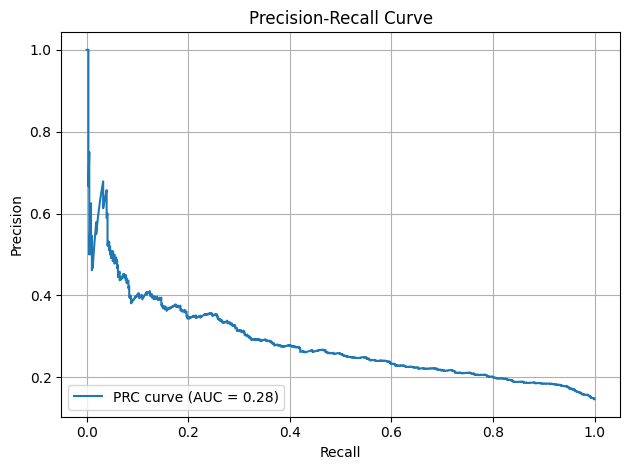

In [22]:
# eval 
evaluate_model(model, test_loader, device)